In [348]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from cvxopt import solvers
from cvxopt import matrix

In [292]:
def generate_data(sample_size, c0_p, c1_p, random_state=124):

    rand = np.random.RandomState(random_state)
    
    c0 = rand.normal(*c0_p, (sample_size, 2))
    c1 = rand.normal(*c1_p, (sample_size, 2))
    c0_l = np.full(sample_size, -1)
    c1_l = np.ones(sample_size)

    x = np.concatenate((c0, c1))
    t = np.concatenate((c0_l, c1_l))
    
    return x, t

def shuffle_data(X, T, random_state=125):
    
    rand = np.random.RandomState(random_state)

    shuffle_mask = np.arange(len(X))
    rand.shuffle(shuffle_mask)

    return X[shuffle_mask], T[shuffle_mask]

X, T = shuffle_data(*generate_data(500, (2, 2), (11, 2)))

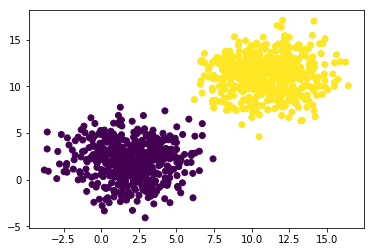

In [293]:
plt.scatter(X[:, 0], X[:, 1], c=T);

In [294]:
from sklearn.model_selection import train_test_split

def train_test_validation(X, T, test_size, random_state=14):
    X_train_, x_travel_, X_test_, t_travel_ = train_test_split(X, T, 
                                                           test_size=test_size, 
                                                           random_state=random_state)
    t_train_, v_train_, t_test_, v_test_ = train_test_split(x_travel_, 
                                                        t_travel_, 
                                                        test_size=0.5, 
                                                        random_state=random_state)
    
    return X_train_, v_train_, t_train_, X_test_, v_test_, t_test_

In [295]:
# split data
X_train, v_train, t_train, X_test, v_test, t_test = train_test_validation(X, T, test_size=0.3)

In [296]:
# define kernel
def kernel(x, x_):
    return x.T.dot(x_)

## Model

In [297]:
class SVM:
    
    def __init__(self, kernel, c):
        self.kernel = kernel
        self.c = c
    
    def train(self, X, T, minimal_support_vector_multiplier=0.05):
        # find multipliers - a
        a = self.__find_multipliers(X, T, minimal_support_vector_multiplier)
        
        # _a is all solutions given by solvers.qp and 
        # is defined for easier debugging, 
        # it may be removed in production. 
        self._a = a
        
        mask = a > minimal_support_vector_multiplier
        
        self.a = a[mask]
        self._supp_vec = X[mask]
        self._supp_vec_t = T[mask]
        
        self.support_vectors_ = (self._supp_vec[self._supp_vec_t == 1], self._supp_vec[self._supp_vec_t == -1])
        
        self.n_supp_vec = np.sum(mask == True)
        
        self.b = self.__find_b()
        
        return self
        
    def predict(self, x, include_b=True):
        b = self.b if include_b else 0
        y = sum([
            self.a[i] * self._supp_vec_t[i] * self.kernel(self._supp_vec[i], x) + b
            for i in range(self.n_supp_vec)
        ])
        return np.sign(y)
    
    def predict_all(self, t_train):
        return np.array([self.predict(x) for x in t_train])
    
    def score(self, t_train, t_test):
        return np.sum(self.predict_all(t_train) == t_test) / len(t_train)
    
    def __find_b(self):
        return sum([
            self._supp_vec_t[n] - self.predict(self._supp_vec[n], include_b=False)
            for n in range(self.n_supp_vec)
        ]) / self.n_supp_vec
    
    def __find_multipliers(self, X, T, minimal_support_vector_multiplier):
        # prepare the parameters for solition
        length = len(X)
        q = matrix(np.full(length, -1, dtype=np.float64))
        P = matrix(np.array([
            t1*t2*self.kernel(x1, x2) for x1, t1 in zip(X, T) for x2, t2 in zip(X, T)
        ]).reshape(-1, length))
        A = matrix(T.reshape(1, length))
        G = matrix(np.concatenate((np.eye(length) * -1, np.eye(length))))
        h = matrix(np.hstack((np.zeros(length), np.full(length, self.c))))
        b = matrix(0.0)
        
        sol = solvers.qp(P=P, q=q, G=G, h=h, A=A, b=b)
        return np.ravel(sol['x'])

Add this decorator to every function (or class)
in which you want cvxopt log to be off.

In [298]:
def off_cvxopt_log(func):
    
    def wrapper(*args, **kwargs):
        solvers.options['show_progress'] = False
        f = func(*args, **kwargs)
        solvers.options['show_progress'] = True
        return f
    
    return wrapper

Find best **hyperparameters** for SVM.

In [299]:
@off_cvxopt_log
def find_best_model(X, T, C, kernel, folds=5, min_mult=0.001):
    
    fold_size = len(X) // folds
    models_and_scores = []
    
    # cross validation
    for fold in range(folds):
        mask = np.ones(len(X), dtype=bool)
        mask[fold * fold_size: (fold + 1) * fold_size] = False
        
        x_train, t_train, x_test, t_test = X[mask], X[~mask], T[mask], T[~mask]
        
        models = [
            SVM(kernel, c).train(x_train, x_test, min_mult)
            for c in C
        ]
        
        models_and_scores.extend([(model, model.score(t_train, t_test)) for model in models])
    
    index = np.argmax(np.array(models_and_scores)[:, 1])
    return models_and_scores[index]

In [300]:
# test train
svm = SVM(kernel, c=0.11)
svm.train(X_train, X_test, 0.001)

     pcost       dcost       gap    pres   dres
 0: -3.4514e+01 -1.1546e+02  3e+03  2e+01  3e-13
 1: -7.0478e+00 -1.0171e+02  3e+02  1e+00  3e-13
 2: -3.2301e+00 -3.2581e+01  4e+01  1e-01  6e-14
 3: -1.2058e+00 -6.7776e+00  9e+00  2e-02  3e-14
 4: -6.7403e-01 -3.1939e+00  4e+00  1e-02  2e-14
 5: -4.9438e-01 -1.6947e+00  2e+00  5e-03  2e-14
 6: -4.3111e-01 -1.1686e+00  1e+00  3e-03  2e-14
 7: -3.4913e-01 -7.1406e-01  5e-01  1e-03  2e-14
 8: -3.5108e-01 -4.0628e-01  8e-02  1e-04  2e-14
 9: -3.4930e-01 -4.0513e-01  7e-02  1e-04  2e-14
10: -3.5483e-01 -3.6269e-01  1e-02  2e-05  2e-14
11: -3.5583e-01 -3.5592e-01  1e-04  2e-07  2e-14
12: -3.5585e-01 -3.5585e-01  1e-06  2e-09  2e-14
13: -3.5585e-01 -3.5585e-01  1e-08  2e-11  2e-14
Optimal solution found.


In [301]:
# possible C values
C = [num for num in np.arange(0.01, 2, 0.05)]
C[:5]

[0.01, 0.060000000000000005, 0.11, 0.16000000000000003, 0.21000000000000002]

In [302]:
best_model, best_score = find_best_model(X_train, X_test, C=[0.11], kernel=kernel)

In [303]:
best_model, best_score, best_model.c

(<__main__.SVM at 0x7f10c40da240>, 1.0, 0.11)

In [304]:
best_model.b

-0.8571428571428571

Support vectors for two different classes shown in *red*.

7 support vectors in total.


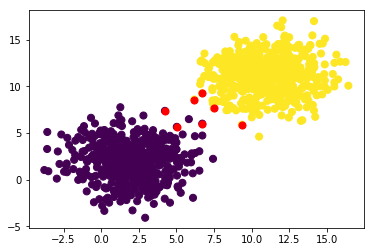

In [305]:
plt.scatter(X[:, 0], X[:, 1], c=T, s=50);
plt.scatter(best_model._supp_vec[:, 0], best_model._supp_vec[:, 1], c='red', s=50);
print(f'{best_model.n_supp_vec} support vectors in total.')

In [306]:
# test on test data
best_model.score(v_train, v_test)

1.0

Since the data is linear separable 
equasion of the line is **-b = w1*x1 + w2*x2**.

In [338]:
w = (best_model._supp_vec_t * best_model.a).dot(best_model._supp_vec)

xs = [np.random.normal(X_train.max(), 0.5), np.random.normal(X_train.min(), 0.5)]
ys = [-(best_model.b + w[0]*x) / w[1] for x in xs]

Decision boundary.

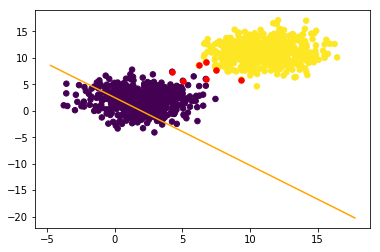

In [308]:
# failed to implement))
plt.scatter(X[:, 0], X[:, 1], c=T, s=30);
plt.scatter(best_model._supp_vec[:, 0], best_model._supp_vec[:, 1], c='red', s=30);
plt.plot(xs, ys, c='orange');

Test the same data on sklearn's SVM.

In [309]:
from sklearn import svm

#                   different C value from implemented model
clf = svm.SVC(kernel='linear', C=1.0)
clf.fit(X_train, X_test)

clf.score(v_train, v_test)

1.0

[1 2] support vectors for each class.


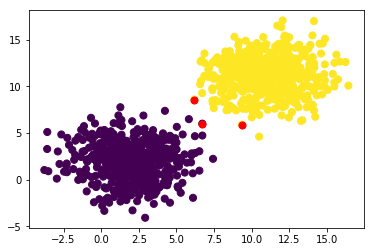

In [310]:
plt.scatter(X[:, 0], X[:, 1], c=T, s=50);
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], c='red', s=50);
print(f'{clf.n_support_} support vectors for each class.')

Decision boundary using SVM from sklearn.

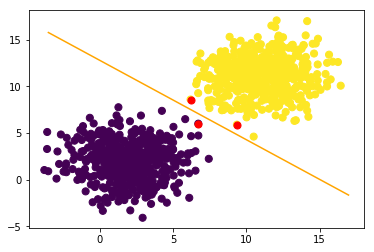

In [311]:
xs = [np.random.normal(X_train.max(), 0.5), np.random.normal(X_train.min(), 0.5)]
ys = [-(clf.intercept_ + clf.coef_[0][0]*x) / clf.coef_[0][1] for x in xs]

plt.scatter(X[:, 0], X[:, 1], c=T, s=50);
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], c='red', s=50);
plt.plot(xs, ys, c='orange');

### Now generate a different(not linearly separately) data.

In [350]:
def distance_2d(x, x_):
    d1, d2 = abs(x[:, 0] - x_[:, 0]), abs(x[:, 1] - x_[:, 1])
    return np.sqrt(d1**2 + d2**2)

X1, _ = generate_data(300, (3, 1), (3, 3), random_state=126)

radius = 6

dists = distance_2d(X1, np.full(X1.shape, 3))

indices = np.argwhere(dists > 2)
index_mask = np.ones(len(X1), dtype=bool)
index_mask[indices] = False

c0, c1 = X1[index_mask], X1[~index_mask]
c0_l, c1_l = np.ones(np.sum(index_mask)), np.full(np.sum(~index_mask), -1)

In [351]:
x_ = np.concatenate((c0, c1))
t_ = np.concatenate((c0_l, c1_l))
X_, T_ = shuffle_data(x_, t_)

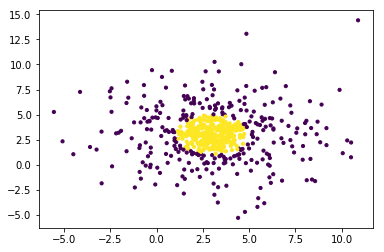

In [352]:
plt.scatter(X_[:, 0], X_[:, 1], c=T_, s=10);

In [353]:
# split data
X_train, v_train, t_train, X_test, v_test, t_test = train_test_validation(X_, T_, test_size=0.4)

Define **guassion kernel**.

In [374]:
def guassion_kernel(x, x_, sigma=0.1):
    # formula is taken from web
    return np.exp(-np.sqrt(np.linalg.norm(x - x_) ** 2 / (2 * sigma ** 2)))

##### Different kernels for non linear SVM.
<img src='kernel.png' width='400px' style='float: left'/>

Find best models for both the *kernel* used befor and *guassian kernel*. 

**Note**: best parameter for both models turns out to be 'C = 0.05', so change c to [0.05] in order to not wait longer. Also the value of *min_mult* is obvious in this case.

In [355]:
c = [n for n in np.arange(0.05, 0.5, 0.1)]

kernel_model, kernel_score = find_best_model(X_train, X_test, C=[0.05], kernel=kernel, min_mult=0.049)
guassion_kernel_model, guassion_kernel_score = find_best_model(
                                                        X_train, X_test, 
                                                        C=[0.05], kernel=guassion_kernel, min_mult=0.049)

In [356]:
kernel_model, kernel_score, kernel_model.c

(<__main__.SVM at 0x7f10c4193e48>, 0.5833333333333334, 0.05)

In [357]:
guassion_kernel_model, guassion_kernel_score, guassion_kernel_model.c

(<__main__.SVM at 0x7f10be7ce518>, 0.9861111111111112, 0.05)

As shown below model using guassian kernel has a better reuslt on validation.

In [358]:
kernel_model.score(v_train, v_test)

0.525

In [361]:
guassion_kernel_model.score(v_train, v_test)

0.975

Support vectors for two different classes shown in *red*.

189 support vectors in total.


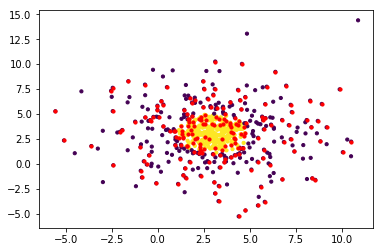

In [372]:
plt.scatter(X_[:, 0], X_[:, 1], c=T_, s=10);
plt.scatter(
    guassion_kernel_model._supp_vec[:, 0], 
    guassion_kernel_model._supp_vec[:, 1], 
    c='red', s=10);

print(f'{guassion_kernel_model.n_supp_vec} support vectors in total.')

Folloring the above case in line equation, except **w**s are many now. 

*Equation*
**-b = w1*x1 + w2*x2 + w3*x3 + ...**

Find **w**s.

In [343]:
guassion_w = (guassion_kernel_model._supp_vec_t * guassion_kernel_model.a).dot(guassion_kernel_model._supp_vec)

Test the same data on sklearn's SVM.

In [362]:
from sklearn import svm

#        different C value from implemented model
clf = svm.SVC(C=1.0)
clf.fit(X_train, X_test)

clf.score(v_train, v_test)

/home/tigran/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9666666666666667

[74 33] support vectors for each class.


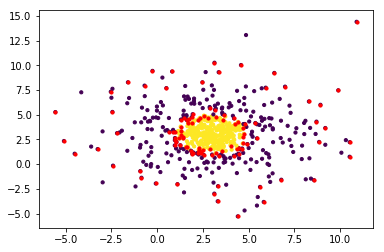

In [377]:
plt.scatter(X_[:, 0], X_[:, 1], c=T_, s=10);
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], c='red', s=10);
print(f'{clf.n_support_} support vectors for each class.')